In [41]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from classy import Class
from matplotlib.lines import Line2D
from smt.sampling_methods import LHS
from matplotlib.pyplot import cm
from uqpylab import sessions
from scipy.interpolate import interp1d
from scipy.spatial.distance import pdist
import statistics as st
import os, sys, warnings
from configparser import ConfigParser
from itertools import chain
import math
import seaborn as sns
from collections import defaultdict

def nested_dict(n, type):
    if n == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: nested_dict(n-1, type))
    
data_kgb = nested_dict(5, list)
data_kev = nested_dict(5, list)

data_kgb_l = nested_dict(5, list)
data_kgb_s = nested_dict(5, list)

import os

# Where to save the figures

IMAGES_PATH = './images'
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="pdf", resolution=180):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    plt.savefig(path, format=fig_extension, dpi=resolution, bbox_inches='tight')

# KGB-evolution

In [42]:
# ──────────────────────────────────────────────────────────────────────────────
#                       CONFIGURATION FLAG
use_all_sims = False# ← set to False to process *only* sim1, True to combine 3
show_sim_plots = True   # ← set to False if you dont want to see the simulation plots,
kgb_sim_data = True
# ──────────────────────────────────────────────────────────────────────────────

# 1) PARAMETERS FOR YOUR SIMULATIONS
sim1 = dict(path='/home/ahmad/kgb-master/output/',
            ngrid=128, boxsize=90000)


# which simulations to stitch?
sims = [sim1]
if use_all_sims:
    sims += [sim2, sim3]


################################################################################################################
#                                              background file
if kgb_sim_data:
    with open(f"{sim1['path']}/file_background.dat") as f:
        lines = f.readlines()

    fourpiG_val = float(next(line.split("=")[1].strip() for line in lines if line.startswith("# fourpiG")))
    H0_val = float(next(line.split("=")[1].strip() for line in lines if line.startswith("# H0[1/Mpc]")))

    norm_kgb = np.sqrt(2*fourpiG_val/3)/H0_val

    bg_kgb = np.loadtxt(f"{sim1['path']}/file_background.dat")

    # scale factor and redshift
    a_kgb = bg_kgb[:,2]
    z_kgb = bg_kgb[:,3]

    # z_kgb = [0 if x < 0 else x for x in z_kgb]
    # z_kgb[-2], z_kgb[-1] = 0.01, 0


    # Conformal Hubble parameter and its derivative 
    Hconf_kgb = bg_kgb[:,5]
    Hconf_prime_kgb = bg_kgb[:,6]
    Hconf_prime_prime_kgb = bg_kgb[:,7]


    # alpha parameters and their derivatives
    alpha_K_kgb = bg_kgb[:,17]
    alpha_B_kgb = bg_kgb[:,18]
    alpha_K_prime_kgb = bg_kgb[:,19]
    alpha_B_prime_kgb = bg_kgb[:,20]

    # dark energy density and pressure and their derivatives
    rho_smg_kgb = bg_kgb[:,13]
    p_smg_kgb = bg_kgb[:,14]
    rho_smg_prime_kgb = bg_kgb[:,15]
    p_smg_prime_kgb = bg_kgb[:,16]
    cs2_kgb = bg_kgb[:,21]

    H_hiclass =  bg_kgb[:,4]

    # other background values
    rho_cdm_kgb = bg_kgb[:,8]
    rho_b_kgb = bg_kgb[:,9]

############################################################################################################ 
#                                         hiclass ini parameters

parser = ConfigParser()
with open(f"{sim1['path']}/file_classparameters.ini") as lines:
    lines = chain(("[top]",), lines) # This line produce a fake section header called top
    parser.read_file(lines)

Omega_fld = float(parser.get("top", "Omega_fld"))
Omega_Lambda = float(parser.get("top", "Omega_Lambda"))
Omega_smg= float(parser.get("top", "Omega_smg"))

Omega_b = float(parser.get("top", "Omega_b"))
Omega_cdm = float(parser.get("top", "Omega_cdm"))
Omega_g = float(parser.get("top", "Omega_g"))
Omega_ur = float(parser.get("top", "Omega_ur"))

# Extract and parse the 'parameters_smg' string
expansion_smg_str = parser.get("top", "expansion_smg")
expansion_smg_list = expansion_smg_str.split(',')
Omega_kgb = float(expansion_smg_list[0].strip())

expansion_model_str = parser.get("top", "expansion_model")

############################################################################################################ 
#                                   KGB-evolution used.ini parameters

with open(f"{sim1['path']}/file_settings_used.ini") as lines:
    lines = chain(("[top]",), lines) # This line produce a fake section header called top
    parser.read_file(lines)

k_pivot = float(parser.get("top", "k_pivot"))     
A_s = float(parser.get("top", "A_s"))   
n_s = float(parser.get("top", "n_s"))
h = float(parser.get("top", "h"))

omega_b = float(parser.get("top", "omega_b"))
omega_cdm = float(parser.get("top", "omega_cdm"))


gravity_model = (parser.get("top", "gravity_model"))
    
# Extract and parse the 'parameters_smg' string
parameters_smg_str = parser.get("top", "parameters_smg")
parameters_smg_list = parameters_smg_str.split(',')
    
# Convert the first two parameters to floats
alpha_K_hat = float(parameters_smg_list[0].strip())
alpha_B_hat = float(parameters_smg_list[1].strip())    



# Function to format numbers for LaTeX (reusing the previous function)
def format_scientific_latex(number):
    mantissa, exponent = f"{number:.1e}".split('e')
    exponent = exponent.lstrip('+').lstrip('0') or '0'
    return f"{mantissa} \\times 10^{{{exponent}}}"

# Format the alpha values
alpha_K_hat_latex = format_scientific_latex(alpha_K_hat)

# Extract and parse the 'parameters_smg' string
expansion_smg_str = parser.get("top", "expansion_smg")
expansion_smg_list = expansion_smg_str.split(',')

w_kgb = float(expansion_smg_list[0].strip())
w_a_kgb = float(expansion_smg_list[1].strip())

# n_kgb_numsteps   = float(parser.get("top", "n_kgb_numsteps"))
Courant_factor = float(parser.get("top", "Courant factor"))

#############################################################################################################3


        ##################################################################################
        #                                                                                #
        #                                                                                #
        #                                 LINKING SIMULATIONS                            #
        #                                                                                #
        #                                                                                #
        ################################################################################## 


# common list of P(k) suffixes
pknames = [
    'delta_kgb',
    'delta',
    'phi',
    'phi_prime',
    'pi_k',
    'zeta',
    'deltakgb_deltam',
]

# read your redshifts once (always from sim1’s ini)
z = []
with open(f"{sim1['path']}/file_settings_used.ini") as f:
    for line in f:
        if line.strip().startswith('Pk redshifts'):
            z = [float(x) for x in line.split('=')[1].split('#')[0].split(',')]
            break

def load_simulation(path, z, pknames):
    data = {name: [] for name in ['k'] + pknames}
    for i in range(len(z)):
        idx = f"{i:02d}"
        got_k = False
        for name in pknames:
            arr = np.loadtxt(f"{path}/pk_0{idx}_{name}.dat")
            if not got_k:
                data['k'].append(arr[:,0])
                got_k = True
            data[name].append(arr[:,1])
    return data

def trim_snapshot(k, fields, ngrid, boxsize,
                  remove_first=5, nyquist_frac=1/13):
    kny = np.pi * ngrid / boxsize
    cutoff = nyquist_frac * kny
    iend = np.argmax(k > cutoff)
    keep = slice(remove_first, iend)
    k_trimmed = k[keep]
    return k_trimmed, {name: arr[keep] for name, arr in fields.items()}

# load whichever sims are needed
data1 = load_simulation(sim1['path'], z, pknames)
if use_all_sims:
    data2 = load_simulation(sim2['path'], z, pknames)
    data3 = load_simulation(sim3['path'], z, pknames)

# prepare output
final = {name: [] for name in ['k'] + pknames}

for iz in range(len(z)):
    # always trim sim1 with the default (remove_first=5, nyquist_frac=1/13)
    k_acc, f_acc = trim_snapshot(
        data1['k'][iz],
        {n: data1[n][iz] for n in pknames},
        sim1['ngrid'], sim1['boxsize']
    )

    if use_all_sims:
        # sim2: remove_first=3, nyquist_frac=1/10
        k2, f2 = trim_snapshot(
            data2['k'][iz],
            {n: data2[n][iz] for n in pknames},
            sim2['ngrid'], sim2['boxsize'],
            remove_first=3,
            nyquist_frac=1/13
        )
        j2 = np.searchsorted(k2, k_acc[-1], side='right')
        k_acc = np.concatenate([k_acc, k2[j2:]])
        for name in pknames:
            f_acc[name] = np.concatenate([f_acc[name], f2[name][j2:]])

        # sim3: remove_first=23, nyquist_frac=0.5
        k3, f3 = trim_snapshot(
            data3['k'][iz],
            {n: data3[n][iz] for n in pknames},
            sim3['ngrid'], sim3['boxsize'],
            remove_first=23,
            nyquist_frac=0.5
        )
        j3 = np.searchsorted(k3, k_acc[-1], side='right')
        k_acc = np.concatenate([k_acc, k3[j3:]])
        for name in pknames:
            f_acc[name] = np.concatenate([f_acc[name], f3[name][j3:]])

    # store result for this redshift
    final['k'].append(k_acc)
    for name in pknames:
        final[name].append(f_acc[name])

# normalize the ‘delta’ spectrum always
for iz in range(len(z)):
    ktot = final['k'][iz]
    norm = (2 * np.pi**2) / (ktot**3)
    final['delta'][iz] *= norm

# Done: if use_all_sims=False you'll have only sim1 trimmed;
# if True you get the 3-sim stitch as before.

# k-evolution

In [43]:
import numpy as np
from configparser import ConfigParser
from itertools import chain

# Configuration Flags for K-essence
use_all_sims_kess = True  # False to process only sim1_kess, True to stitch all three
show_sim_plots_kess = True  # Toggle simulation plots
kess_sim_data = True  # Load background data

# 1) Simulation Definitions for K-essence
sim1_kess = dict(
    path="/home/ahmad/kgb-master/data/3072-90000-ab=0/", ngrid=3072, boxsize=90000
)
sim2_kess = dict(
    path="/home/ahmad/kgb-master/data/4096-15000-ab=0/", ngrid=4096, boxsize=15000
)
sim3_kess = dict(
    path="/home/ahmad/kgb-master/data/3072-4000-ab=0/", ngrid=3072, boxsize=4000
)

# Select which simulations to stitch
sims_kess = [sim1_kess]
if use_all_sims_kess:
    sims_kess += [sim2_kess, sim3_kess]

# Load background quantities from sim1_kess
if kess_sim_data:
    with open(f"{sim1_kess['path']}/file_background.dat") as f:
        lines = f.readlines()

    fourpiG_val_kess = float(
        next(
            line.split("=")[1].strip() for line in lines if line.startswith("# fourpiG")
        )
    )
    H0_val_kess = float(
        next(
            line.split("=")[1].strip()
            for line in lines
            if line.startswith("# H0[1/Mpc]")
        )
    )
    norm_kess = np.sqrt(2 * fourpiG_val_kess / 3) / H0_val_kess

    bg_kess = np.loadtxt(f"{sim1_kess['path']}/file_background.dat")
    a_kess = bg_kess[:, 2]
    z_kess = bg_kess[:, 3]
    Hconf_kess = bg_kess[:, 5]
    Hconf_prime_kess = bg_kess[:, 6]
    Hconf_prime_prime_kess = bg_kess[:, 7]

    alpha_K_kess = bg_kess[:, 17]
    alpha_B_kess = bg_kess[:, 18]
    alpha_K_prime_kess = bg_kess[:, 19]
    alpha_B_prime_kess = bg_kess[:, 20]

    rho_smg_kess = bg_kess[:, 13]
    p_smg_kess = bg_kess[:, 14]
    rho_smg_prime_kess = bg_kess[:, 15]
    p_smg_prime_kess = bg_kess[:, 16]
    cs2_kess = bg_kess[:, 21]

    H_hiclass_kess = bg_kess[:, 4]
    rho_cdm_kess = bg_kess[:, 8]
    rho_b_kess = bg_kess[:, 9]

# Read INI parameters (class settings) from sim1_kess
parser_kess = ConfigParser()
with open(f"{sim1_kess['path']}/file_classparameters.ini") as lines:
    lines = chain(("[top]",), lines)
    parser_kess.read_file(lines)

Omega_fld_kess = float(parser_kess.get("top", "Omega_fld"))
Omega_Lambda_kess = float(parser_kess.get("top", "Omega_Lambda"))
Omega_smg_kess = float(parser_kess.get("top", "Omega_smg"))
Omega_b_kess = float(parser_kess.get("top", "Omega_b"))
Omega_cdm_kess = float(parser_kess.get("top", "Omega_cdm"))
Omega_g_kess = float(parser_kess.get("top", "Omega_g"))
Omega_ur_kess = float(parser_kess.get("top", "Omega_ur"))

# Read evolution settings (KGB-evolution) from sim1_kess
with open(f"{sim1_kess['path']}/file_settings_used.ini") as lines:
    lines = chain(("[top]",), lines)
    parser_kess.read_file(lines)

k_pivot_kess = float(parser_kess.get("top", "k_pivot"))
A_s_kess = float(parser_kess.get("top", "A_s"))
n_s_kess = float(parser_kess.get("top", "n_s"))
h_kess = float(parser_kess.get("top", "h"))
omega_b_kess = float(parser_kess.get("top", "omega_b"))
omega_cdm_kess = float(parser_kess.get("top", "omega_cdm"))

params_smg_kess = parser_kess.get("top", "parameters_smg").split(",")
alpha_K_hat_kess = float(params_smg_kess[0].strip())
alpha_B_hat_kess = float(params_smg_kess[1].strip())

# Common list of P(k) suffixes
pknames_kess = [
    "delta_kgb",
    "delta",
    "phi",
    "phi_prime",
    "pi_k",
    "zeta",
    "deltakgb_deltam",
]

# Read redshifts (always from sim1_kess)
z_kess = []
with open(f"{sim1_kess['path']}/file_settings_used.ini") as f:
    for line in f:
        if line.strip().startswith("Pk redshifts"):
            z_kess = [float(x) for x in line.split("=")[1].split("#")[0].split(",")]
            break

# Function to load simulation data
def load_sim_kess(path, z, pknames):
    data = {name: [] for name in ["k"] + pknames}
    for i in range(len(z)):
        idx = f"{i:02d}"
        got_k = False
        for name in pknames:
            arr = np.loadtxt(f"{path}/pk_0{idx}_{name}.dat")
            if not got_k:
                data["k"].append(arr[:, 0])
                got_k = True
            data[name].append(arr[:, 1])
    return data


# Function to trim simulation snapshots
def trim_snap_kess(k, fields, ngrid, boxsize, remove_first=5, nyquist_frac=1/ 13):
    kny = np.pi * ngrid / boxsize
    cutoff = nyquist_frac * kny
    iend = np.argmax(k > cutoff)
    keep = slice(remove_first, iend)
    return k[keep], {name: arr[keep] for name, arr in fields.items()}


# Load and stitch P(k) data
data1_kess = load_sim_kess(sim1_kess["path"], z_kess, pknames_kess)
if use_all_sims_kess:
    data2_kess = load_sim_kess(sim2_kess["path"], z_kess, pknames_kess)
    data3_kess = load_sim_kess(sim3_kess["path"], z_kess, pknames_kess)

final_kess = {name: [] for name in ["k"] + pknames_kess}
for iz in range(len(z_kess)):
    k_acc, f_acc = trim_snap_kess(
        data1_kess["k"][iz],
        {n: data1_kess[n][iz] for n in pknames_kess},
        sim1_kess["ngrid"],
        sim1_kess["boxsize"],
    )
    if use_all_sims_kess:
        k2, f2 = trim_snap_kess(
            data2_kess["k"][iz],
            {n: data2_kess[n][iz] for n in pknames_kess},
            sim2_kess["ngrid"],
            sim2_kess["boxsize"],
            remove_first=3,
            nyquist_frac=1 / 13,
        )
        j2 = np.searchsorted(k2, k_acc[-1], side="right")
        k_acc = np.concatenate([k_acc, k2[j2:]])
        for name in pknames_kess:
            f_acc[name] = np.concatenate([f_acc[name], f2[name][j2:]])
        k3, f3 = trim_snap_kess(
            data3_kess["k"][iz],
            {n: data3_kess[n][iz] for n in pknames_kess},
            sim3_kess["ngrid"],
            sim3_kess["boxsize"],
            remove_first=23,
            nyquist_frac=0.5,
        )
        j3 = np.searchsorted(k3, k_acc[-1], side="right")
        k_acc = np.concatenate([k_acc, k3[j3:]])
        for name in pknames_kess:
            f_acc[name] = np.concatenate([f_acc[name], f3[name][j3:]])
    final_kess["k"].append(k_acc)
    for name in pknames_kess:
        final_kess[name].append(f_acc[name])

# Normalize the 'delta' spectrum for K-essence
for iz in range(len(z_kess)):
    ktot_kess = final_kess["k"][iz]
    norm_factor = (2 * np.pi**2) / (ktot_kess**3)
    final_kess["delta"][iz] *= norm_factor

# Output: final_kess['k'] and final_kess[...] contain your stitched K-essence P(k) data.

In [44]:
print(
    "Omega_b =",
    Omega_b,
    "\n",
    "Omega_cdm =",
    Omega_cdm,
    "\n",
    "Omega_g =",
    Omega_g,
    "\n",
    "Omega_ur =",
    Omega_ur,
    "\n",
    "Omega_kgb =",
    Omega_kgb,
    "\n",
    "Omega_fld =",
    Omega_fld,
    "\n",
    "Omega_Lambda =",
    Omega_Lambda,
    "\n",
    "Omega_smg =",
    Omega_smg,
    "\n",
    "h =",
    h,
    "\n",
    "A_s =",
    A_s,
    "\n",
    "n_s =",
    n_s,
    "\n",
    "alpha_K_hat =",
    alpha_K_hat,
    "\n",
    "alpha_B_hat =",
    alpha_B_hat,
    "\n",
    "Omega_kgb =",
    Omega_kgb,
    "\n",
    "w_0 =",
    w_kgb,
    "\n",
    "w_a =",
    w_a_kgb,
    "\n",
    "gravity_model =",
    gravity_model,
    "\n",
    "expansion_model =",
    expansion_model_str,
)

Omega_b = 0.04827542 
 Omega_cdm = 0.2637707 
 Omega_g = 5.418479e-05 
 Omega_ur = 3.748335e-05 
 Omega_kgb = 0.6878623 
 Omega_fld = 0.0 
 Omega_Lambda = 0.0 
 Omega_smg = -1.0 
 h = 0.67556 
 A_s = 2.215e-09 
 n_s = 0.9619 
 alpha_K_hat = 3000.0 
 alpha_B_hat = 3.75 
 Omega_kgb = 0.6878623 
 w_0 = -0.9 
 w_a = 0.0 
 gravity_model = propto_omega 
 expansion_model = wowa


# hiclass KGB

In [45]:
# z = [50,2,1,0.0]
# kk = np.logspace(-3.2, np.log10(10), 1000)  # k in h/Mpc

alpha_K_hat = 3e+03
alpha_B_hat = 3.75

kk = ktot

def a(x):
    return 1/(1+x)


Pk_m_kgb = [None] * len(z)
Pk_smg_kgb = [None] * len(z)

Pk_phi_kgb = [None] * len(z)
Pk_phi_prime_kgb = [None] * len(z)


Pk_pi_k_kgb = [None] * len(z)
Pk_zeta_kgb = [None] * len(z)

#######################################################################################
#                                               KGB settings
kgb_settings = {
    "Omega_smg": Omega_smg,
    "Omega_Lambda": Omega_Lambda,
    "Omega_fld": Omega_fld,
    "h": h,
    "Omega_b": Omega_b,
    "Omega_cdm": Omega_cdm,
    "Omega_g":Omega_g,
    "Omega_ur":Omega_ur,
    "A_s": A_s,
    "n_s": n_s,
    "z_max_pk": 100,
    "gravity_model": f"{gravity_model}",
    "parameters_smg": f"{alpha_K_hat}, {alpha_B_hat}, 0, 0, 1",
    "expansion_model": expansion_model_str,
    "expansion_smg": f"{Omega_kgb},{w_kgb}, {w_a_kgb}",
    "extra metric transfer functions": "yes",
    "output": "dTk,vTk,mPk",
    "P_k_max_1/Mpc": 130,
}

M_kgb = Class()
M_kgb.set(kgb_settings)
M_kgb.compute()
######################################################################################


######################################################################################
#                                                 common parameters

#kk = np.logspace(-3.2, np.log10(10), 1000)  # k in h/Mpc
k_pivot = 0.05
h = M_kgb.h()
As = kgb_settings["A_s"]
ns = kgb_settings["n_s"]
Normalization = As * (kk / k_pivot) ** (ns - 1.0)

######################################################################################
#                                                    backgrounds

backgrounds = M_kgb.get_background()

rho_b = interp1d(backgrounds["z"], backgrounds["(.)rho_b"], kind="cubic")
rho_cdm = interp1d(backgrounds["z"], backgrounds["(.)rho_cdm"], kind="cubic")
rho_g = interp1d(backgrounds["z"], backgrounds["(.)rho_g"], kind="cubic")
rho_ur = interp1d(backgrounds["z"], backgrounds["(.)rho_ur"], kind="cubic")
rho_tot = interp1d(backgrounds["z"], backgrounds["(.)rho_tot"], kind="cubic")
rho_crit = interp1d(backgrounds["z"], backgrounds["(.)rho_crit"], kind="cubic")

H = interp1d(backgrounds["z"], backgrounds["H [1/Mpc]"], kind="cubic")
H_prime = interp1d(backgrounds["z"], backgrounds["H_prime"], kind="cubic")


rho_smg = interp1d(backgrounds["z"], backgrounds["(.)rho_smg"], kind="cubic")
rho_smg_prime = interp1d(backgrounds["z"], backgrounds["(.)rho_smg_prime"], kind="cubic")
p_smg = interp1d(backgrounds["z"], backgrounds["(.)p_smg"], kind="cubic")
alpha_K = interp1d(backgrounds["z"], backgrounds["kineticity_smg"], kind="cubic")
alpha_B = interp1d(backgrounds["z"], backgrounds["braiding_smg"], kind="cubic")

a_hi = 1.0 / (1.0 + backgrounds["z"])
a_hiclass = interp1d(backgrounds["z"], a_hi, kind="cubic")
z_hi = backgrounds["z"]

Hconf = interp1d(backgrounds["z"], backgrounds["H [1/Mpc]"] * a_hi)
Hconf_prime = interp1d(
    backgrounds["z"],
    (a_hi**2) * (backgrounds["H [1/Mpc]"] ** 2) + a_hi * backgrounds["H_prime"],
)

H0 = Hconf(0)
Mpl2 = 1 / (3.0 * H0** 2)

############################################################################################


for zind, z_val in enumerate(z):

    #######################################################################################
    #                                                 Transfer functions

    Transfers = M_kgb.get_transfer(z_val)

    #############
    delta_b = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_b"], kind="cubic"
    )
    theta_b = interp1d(
        Transfers["k (h/Mpc)"], Transfers["t_b"], kind="cubic"
    )
    #############
    #                         theta_cdm is zero in synchronous gauge
    delta_cdm = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_cdm"], kind="cubic"
    )
    #############
    delta_g = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_g"], kind="cubic"
    )
    theta_g = interp1d(
        Transfers["k (h/Mpc)"], Transfers["t_g"], kind="cubic"
    )
    #############
    delta_ur = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_ur"], kind="cubic"
    )
    theta_ur = interp1d(
        Transfers["k (h/Mpc)"], Transfers["t_ur"], kind="cubic"
    )
    #############

    delta_tot = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_tot"], kind="cubic"
    )

    theta_tot = interp1d(
        Transfers["k (h/Mpc)"], Transfers["t_tot"], kind="cubic"
    )

    phi = interp1d(Transfers["k (h/Mpc)"], Transfers["phi"], kind="cubic")
    phi_prime = interp1d(
        Transfers["k (h/Mpc)"], Transfers["phi_prime"], kind="cubic"
    )
    psi = interp1d(Transfers["k (h/Mpc)"], Transfers["psi"], kind="cubic")

    vx_smg = interp1d(Transfers["k (h/Mpc)"], Transfers["vx_smg"], kind="cubic")
    vx_prime_smg = interp1d(
        Transfers["k (h/Mpc)"], Transfers["vx_prime_smg"], kind="cubic"
    )
    eta = interp1d(Transfers["k (h/Mpc)"], Transfers["eta"], kind="cubic")
    eta_prime = interp1d(
        Transfers["k (h/Mpc)"], Transfers["eta_prime"], kind="cubic"
    )

    h_met = interp1d(Transfers["k (h/Mpc)"], Transfers["h"], kind="cubic")
    h_prime_met = interp1d(
        Transfers["k (h/Mpc)"], Transfers["h_prime"], kind="cubic"
    )


    tmp_m_kgb = []
    tmp_m_kgb_newt = []
    tmp_smg_kgb = []
    
    tmp_phi_kgb = []
    tmp_phi_prime_kgb = []
    
    tmp_pi_k_kgb = []
    tmp_zeta_kgb = []


    for k in kk:
        
        alpha = (h_prime_met(k) + 6.0 * eta_prime(k)) / (2.0 * k * k * h * h)
        alpha_prime = psi(k) - Hconf(z_val) * alpha

        pi_newt = -vx_smg(k) + alpha
        pi_prime_newt = -vx_prime_smg(k) + alpha_prime
        zeta_newt = Hconf(z_val) * pi_newt + pi_prime_newt - psi(k)

        delta_smg_newt = (
            (Mpl2 / a(z_val) ** 2)
            * (
                -alpha_B(z_val) * Hconf(z_val) * ((k * h) ** 2) * pi_newt
                + 3 * alpha_B(z_val) * (Hconf(z_val) ** 2) * psi(k)
                - (3 * alpha_B(z_val) + alpha_K(z_val))
                * (Hconf(z_val) ** 2)
                * zeta_newt
                + 3 * alpha_B(z_val) * Hconf(z_val) * phi_prime(k)
            )
            + (
                (Mpl2 * alpha_B(z_val) / (a(z_val) ** 2))
                * (Hconf_prime(z_val) - Hconf(z_val) ** 2)
                + ((rho_smg(z_val) + p_smg(z_val)) / H0**2)
            )
            * 3
            * Hconf(z_val)
            * pi_newt
        ) / (rho_smg(z_val) / H0**2)
        
        
        # gauge transformation
        
        delta_smg_syn = delta_smg_newt + alpha * rho_smg_prime(z_val) / rho_smg(z_val)
        
        delta_cdm_newt = delta_cdm(k) - 3* alpha * Hconf(z_val)
        
        delta_b_newt = delta_b(k) - 3 * alpha * Hconf(z_val)
        
        delta_cdm_b_newt = (rho_cdm(z_val)*delta_cdm_newt+rho_b(z_val)*delta_b_newt)/(rho_cdm(z_val)+rho_b(z_val))
        
        tmp_m_kgb_newt.append((2* (np.pi**2)/((k)**3))*delta_cdm_b_newt**2)
        
        tmp_m_kgb.append(M_kgb.pk(k * h, z_val) * h**3)

        tmp_smg_kgb.append(delta_smg_newt**2)
        
        tmp_phi_kgb.append((k*h)*phi(k)**2)
        tmp_phi_prime_kgb.append((k*h)*phi_prime(k)**2)
        
        tmp_pi_k_kgb.append((k*h)**2 * pi_newt**2)
        tmp_zeta_kgb.append( zeta_newt**2)
        
#########################################################################################################
#                                        Calculating Spectra
        
  ### matter power spectrum  

    # using transfer function
    Pk_m_kgb[zind] =  Normalization * tmp_m_kgb_newt
    
    # using the direct function
#     Pk_m_kgb[zind] = tmp_m_kgb

 #### DE power spectrum
    Pk_smg_kgb[zind] = Normalization * np.array(tmp_smg_kgb)
    
    # phi power spectrum
    Pk_phi_kgb[zind] =  Normalization * tmp_phi_kgb
    
    # phi_prime power spectrum
    Pk_phi_prime_kgb[zind] =  Normalization * tmp_phi_prime_kgb/H0**2
    
    # pi_k power spectrum
    Pk_pi_k_kgb[zind] =  Normalization * tmp_pi_k_kgb*(H0**2)
    
    # zeta power spectrum
    Pk_zeta_kgb[zind] =  Normalization * tmp_zeta_kgb
    
    
    

# hiclass kessence

In [46]:
Pk_m_kess = [None] * len(z)
Pk_smg_kess = [None] * len(z)
delta_smg_kess = [None] * len(z)

Pk_phi_kess = [None] * len(z)
Pk_phi_prime_kess = [None] * len(z)

Pk_pi_k_kess = [None] * len(z)
Pk_zeta_kess = [None] * len(z)

#######################################################################################
#                                               kessence settings

kess_settings = kgb_settings.copy()
kess_settings["parameters_smg"] = f"{alpha_K_hat}, 0, 0, 0, 1"
#kess_settings["use_ppf"] = "yes"
M_kess = Class()
M_kess.set(kess_settings)
M_kess.compute()

####################################################################################

######################################################################################
#                                                   backgrounds

backgrounds = M_kess.get_background()

rho_b = interp1d(backgrounds["z"], backgrounds["(.)rho_b"], kind="cubic")
rho_cdm = interp1d(backgrounds["z"], backgrounds["(.)rho_cdm"], kind="cubic")
rho_g = interp1d(backgrounds["z"], backgrounds["(.)rho_g"], kind="cubic")
rho_ur = interp1d(backgrounds["z"], backgrounds["(.)rho_ur"], kind="cubic")
rho_tot = interp1d(backgrounds["z"], backgrounds["(.)rho_tot"], kind="cubic")
rho_crit = interp1d(backgrounds["z"], backgrounds["(.)rho_crit"], kind="cubic")

H = interp1d(backgrounds["z"], backgrounds["H [1/Mpc]"], kind="cubic")
H_prime = interp1d(backgrounds["z"], backgrounds["H_prime"], kind="cubic")


rho_smg = interp1d(backgrounds["z"], backgrounds["(.)rho_smg"], kind="cubic")
rho_smg_prime = interp1d(backgrounds["z"], backgrounds["(.)rho_smg_prime"], kind="cubic")
p_smg = interp1d(backgrounds["z"], backgrounds["(.)p_smg"], kind="cubic")
alpha_K = interp1d(backgrounds["z"], backgrounds["kineticity_smg"], kind="cubic")
alpha_B = interp1d(backgrounds["z"], backgrounds["braiding_smg"], kind="cubic")

a_hi = 1.0 / (1.0 + backgrounds["z"])
a_hiclass = interp1d(backgrounds["z"], a_hi, kind="cubic")
z_hi = backgrounds["z"]

Hconf = interp1d(backgrounds["z"], backgrounds["H [1/Mpc]"] * a_hi)
Hconf_prime = interp1d(
    backgrounds["z"],
    (a_hi**2) * (backgrounds["H [1/Mpc]"] ** 2) + a_hi * backgrounds["H_prime"],
)

H0 = Hconf(0)
Mpl2 = 1 / (3.0 * H0** 2)


for zind, z_val in enumerate(z):

    #######################################################################################
    #                                                 Transfer functions

    Transfers = M_kess.get_transfer(z_val)

    #############
    delta_b = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_b"], kind="cubic"
    )
    theta_b = interp1d(
        Transfers["k (h/Mpc)"], Transfers["t_b"], kind="cubic"
    )
    #############
    #                         theta_cdm is zero in synchronous gauge
    delta_cdm = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_cdm"], kind="cubic"
    )
    #############
    delta_g = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_g"], kind="cubic"
    )
    theta_g = interp1d(
        Transfers["k (h/Mpc)"], Transfers["t_g"], kind="cubic"
    )
    #############
    delta_ur = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_ur"], kind="cubic"
    )
    theta_ur = interp1d(
        Transfers["k (h/Mpc)"], Transfers["t_ur"], kind="cubic"
    )
    #############

    delta_tot = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_tot"], kind="cubic"
    )

    theta_tot = interp1d(
        Transfers["k (h/Mpc)"], Transfers["t_tot"], kind="cubic"
    )

    phi = interp1d(Transfers["k (h/Mpc)"], Transfers["phi"], kind="cubic")
    phi_prime = interp1d(
        Transfers["k (h/Mpc)"], Transfers["phi_prime"], kind="cubic"
    )
    psi = interp1d(Transfers["k (h/Mpc)"], Transfers["psi"], kind="cubic")

    vx_smg = interp1d(Transfers["k (h/Mpc)"], Transfers["vx_smg"], kind="cubic")
    vx_prime_smg = interp1d(
        Transfers["k (h/Mpc)"], Transfers["vx_prime_smg"], kind="cubic"
    )
    eta = interp1d(Transfers["k (h/Mpc)"], Transfers["eta"], kind="cubic")
    eta_prime = interp1d(
        Transfers["k (h/Mpc)"], Transfers["eta_prime"], kind="cubic"
    )

    h_met = interp1d(Transfers["k (h/Mpc)"], Transfers["h"], kind="cubic")
    h_prime_met = interp1d(
        Transfers["k (h/Mpc)"], Transfers["h_prime"], kind="cubic"
    )


    tmp_m_kess_ = []
    tmp_m_kess_newt = []
    tmp_smg_kess = []
    
    tmp_phi_kess = []
    tmp_phi_prime_kess = []
        
    tmp_pi_k_kess = []
    tmp_zeta_kess = []


    for k in kk:
        
        alpha = (h_prime_met(k) + 6.0 * eta_prime(k)) / (2.0 * k * k * h * h)
        alpha_prime = psi(k) - Hconf(z_val) * alpha

        pi_newt = -vx_smg(k) + alpha
        pi_prime_newt = -vx_prime_smg(k) + alpha_prime
        zeta_newt = Hconf(z_val) * pi_newt + pi_prime_newt - psi(k)

        delta_smg_newt = (
            (Mpl2 / a(z_val) ** 2)
            * (
                -alpha_B(z_val) * Hconf(z_val) * ((k * h) ** 2) * pi_newt
                + 3 * alpha_B(z_val) * (Hconf(z_val) ** 2) * psi(k)
                - (3 * alpha_B(z_val) + alpha_K(z_val))
                * (Hconf(z_val) ** 2)
                * zeta_newt
                + 3 * alpha_B(z_val) * Hconf(z_val) * phi_prime(k)
            )
            + (
                (Mpl2 * alpha_B(z_val) / (a(z_val) ** 2))
                * (Hconf_prime(z_val) - Hconf(z_val) ** 2)
                + ((rho_smg(z_val) + p_smg(z_val)) / H0**2)
            )
            * 3
            * Hconf(z_val)
            * pi_newt
        ) / (rho_smg(z_val) / H0**2)
        
        
        # gauge transformation
        
        delta_smg_syn = delta_smg_newt + alpha * rho_smg_prime(z_val) / rho_smg(z_val)
        
        delta_cdm_newt = delta_cdm(k) - 3* alpha * Hconf(z_val)
        
        delta_b_newt = delta_b(k) - 3 * alpha * Hconf(z_val)
        
        delta_cdm_b_newt = (rho_cdm(z_val)*delta_cdm_newt+rho_b(z_val)*delta_b_newt)/(rho_cdm(z_val)+rho_b(z_val))
        
        tmp_m_kess_newt.append((2* (np.pi**2)/((k)**3))*delta_cdm_b_newt**2)
        
        #tmp_m_kess.append(M_kess.pk(k * h, z_val) * h**3)

        tmp_smg_kess.append(delta_smg_newt**2)
        
        tmp_phi_kess.append((k*h)*phi(k)**2)
        
        tmp_phi_prime_kess.append((k*h)*phi_prime(k)**2)
        
        tmp_pi_k_kess.append((k*h)**2 * pi_newt**2)
        tmp_zeta_kess.append( zeta_newt**2)
        
  ### matter power spectrum  
    Pk_m_kess[zind] = Normalization * tmp_m_kess_newt
    
 ### phi power spectrum  
    Pk_phi_kess[zind] = Normalization * tmp_phi_kess
    
 ### phi_prime power spectrum  
    Pk_phi_prime_kess[zind] = Normalization * tmp_phi_prime_kess/H0**2
    
 #### DE power spectrum
    Pk_smg_kess[zind] = Normalization * np.array(tmp_smg_kess)
    
  ####
#     delta_smg_kess[zind] = d_smg_kess
    
    # pi_k power spectrum
    Pk_pi_k_kess[zind] =  Normalization * tmp_pi_k_kess*(H0**2)
    
    # zeta power spectrum
    Pk_zeta_kess[zind] =  Normalization * tmp_zeta_kess



## matter power spectrum

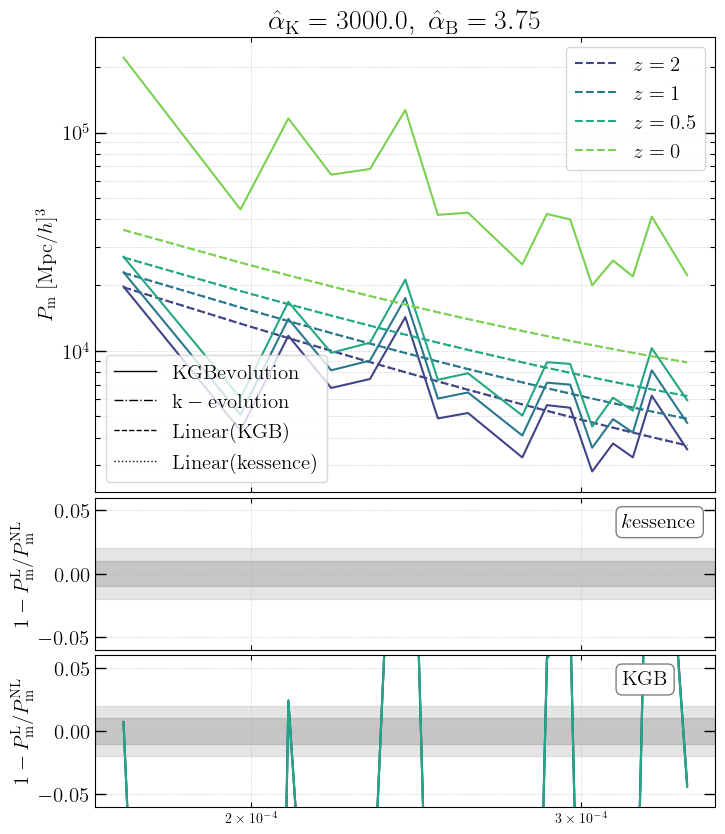

In [47]:
fig, ax = plt.subplots(
    3, 1, gridspec_kw={"height_ratios": [3, 1,1]}, figsize=(8, 10), sharex=True
)
plt.subplots_adjust(hspace=0.022, wspace=0.23)


#c = sns.color_palette("viridis", len(z)).as_hex()

plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 18}

# simulation KGB
k_zp     = dict(zip(z, final['k']))
delta_zp = dict(zip(z, final['delta']))

# simulation kessence
delta_kess_zp = dict(zip(z, final_kess['delta']))


# hiclass
Pk_m_kgb_zp  = dict(zip(z, Pk_m_kgb))
Pk_m_kess_zp = dict(zip(z, Pk_m_kess))



# 2) Choose the redshifts you actually want to plot
target_z = [ 2, 1, 0.5, 0]

colors = sns.color_palette("viridis", len(target_z)).as_hex()



for c, zv in zip(colors, target_z):
    
    # simulation
    k_vals     = k_zp[zv]
    delta_vals = delta_zp[zv]
    delta_kess_vals = delta_kess_zp[zv]
    
    # hiclass
    Pk_m_kgb_vals =Pk_m_kgb_zp[zv]
    Pk_m_kess_vals =Pk_m_kess_zp[zv]
    

    #############################################################################
    #                                         hiclass
    
    
    ax[0].plot(
        k_vals,
        Pk_m_kgb_vals,"--",
        label=f"$z={zv}$",
        c = c,
        alpha = 1,
        markersize=6
    )
    
    
    ax[0].plot(
        k_vals,
        Pk_m_kess_vals,":",
        c = c,
        markersize=6
    )
    
    
    #############################################################################
    #                                         KGB-evolution
    if show_sim_plots:
        
    
        ax[0].plot(
            k_vals,
            delta_vals,"-",
            c = c,
            alpha =1,
            markersize=6
        )
        

    
    
    
    
    ##############################################################################
    #                                         Rel Diff
    

    ax[2].plot(
        kk,
        (1-np.array(Pk_m_kgb_vals)/delta_vals),"-",
        c = c,
        markersize=6
    )
    
    


    
    

linestyles = ["-","-.", "--", ":"]
lines = [Line2D([0], [0], color="black", linewidth=1, linestyle=l) for l in linestyles]
labels = [f"$\mathrm{{KGBevolution}}$ ", f"$\mathrm{{k-evolution}}$ ",f"$\mathrm{{Linear(KGB)}}$", f"$\mathrm{{Linear(kessence)}}$"]


leg2 = ax[0].legend(lines, labels, loc="lower left", fontsize=15)

ax[0].add_artist(leg2)

ax[0].legend(fontsize=15)    
    
    
for i in range(1,3):
    ax[i].set_ylim(-0.06,0.06)

    ax[i].axhspan(-0.01, 0.01, color="gray", alpha=0.3)
    ax[i].axhspan(-0.02, 0.02, color="gray", alpha=0.2)

for i in range(3):
    ax[i].set_xscale("log")
    

    # plt.xlim(5.0e-5, 0.01)
    # plt.ylim(1.e-17,3.e-9)
    ax[i].grid(which="both", axis="both", linestyle="--", linewidth=0.5, alpha = 0.5)


    ax[i].tick_params("both", length=8, width=1, which="major")
    ax[i].tick_params("both", length=3.5, width=0.8, which="minor")
    ax[i].tick_params(direction="in", which="major", labelsize=15)
    ax[i].tick_params(direction="in", which="minor")
    ax[i].yaxis.set_ticks_position("both")
    ax[i].xaxis.set_ticks_position("both")


ax[0].set_yscale("log")
ax[0].set_ylabel(r"$P_\mathrm{m}~ [\mathrm{Mpc}/h]^3$", fontsize=15)
ax[1].set_ylabel(r"$1-P_\mathrm{m}^\mathrm{L }/P_\mathrm{m}^\mathrm{NL}$", fontsize=15)
ax[2].set_ylabel(r"$1-P_\mathrm{m}^\mathrm{L }/P_\mathrm{m}^\mathrm{NL}$", fontsize=15)
ax[1].set_xlabel("$k~ [h/\mathrm{Mpc}]$", fontsize=15)

ax[1].text(.85, 0.9, r'$k\mathrm{essence}$',
           transform=ax[1].transAxes,
           fontsize=15, ha='left', va='top',
           bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))
ax[2].text(0.85, 0.9, r'$\mathrm{KGB}$',
           transform=ax[2].transAxes,
           fontsize=15, ha='left', va='top',
           bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))


ax[0].legend(
    fontsize=15,  # Font size
    loc="upper right",  # Place legend above the plot
#     bbox_to_anchor=(1.23, 1.03),  # Position outside plot area (x, y relative to axes)
#     ncol=1,  # Number of columns
)





ax[0].set_title(
    rf"$\hat{{\alpha}}_{{\mathrm{{K}}}} = {alpha_K_hat},\ \hat{{\alpha}}_{{\mathrm{{B}}}} = {alpha_B_hat}$",
    fontsize=20,
)


plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 15}

#save_fig("matter_power_spectrum")

# $\Phi'$ power spectrum

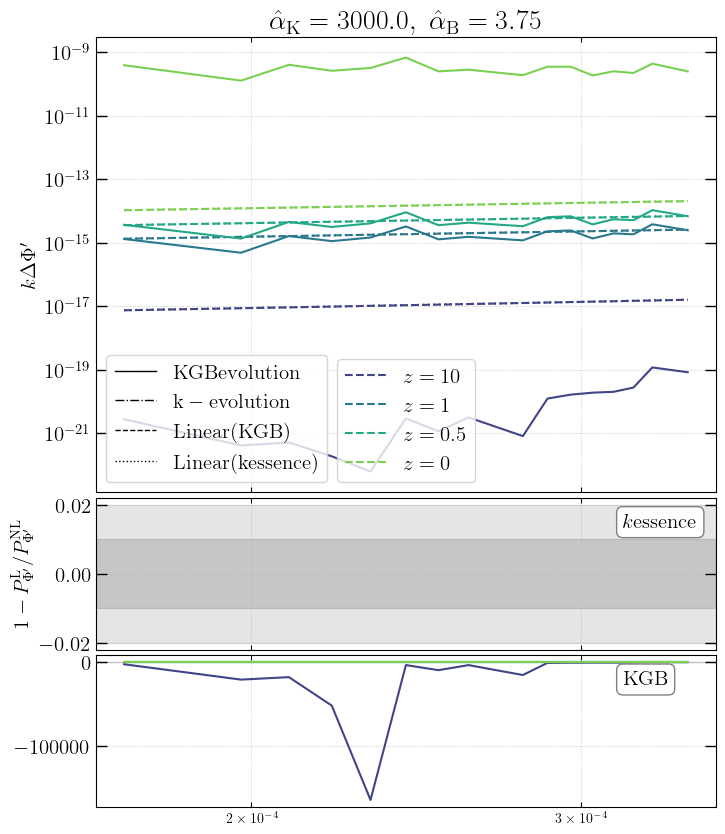

In [48]:
fig, ax = plt.subplots(
    3, 1, gridspec_kw={"height_ratios": [3, 1,1]}, figsize=(8, 10), sharex=True
)
plt.subplots_adjust(hspace=0.022, wspace=0.23)


#c = sns.color_palette("viridis", len(z)).as_hex()

plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 18}

# simulation
k_zp     = dict(zip(z, final['k']))
phi_prime_zp = dict(zip(z, final['phi_prime']))

# simulation kessence
phi_prime_kess_zp = dict(zip(z, final_kess['phi_prime']))


# hiclass
Pk_phi_prime_kgb_zp  = dict(zip(z, Pk_phi_prime_kgb))
Pk_phi_prime_kess_zp = dict(zip(z, Pk_phi_prime_kess))



# 2) Choose the redshifts you actually want to plot
target_z = [10, 1, 0.5, 0]

colors = sns.color_palette("viridis", len(target_z)).as_hex()



for c, zv in zip(colors, target_z):
    
    # simulation
    k_vals     = k_zp[zv]
    phi_prime_vals = k_vals*h*phi_prime_zp[zv]

    
    # hiclass
    Pk_phi_prime_kgb_vals = Pk_phi_prime_kgb_zp[zv]
    Pk_phi_prime_kess_vals = Pk_phi_prime_kess_zp[zv]
    

    #############################################################################
    #                                         hiclass
    
    
    ax[0].plot(
        k_vals,
        Pk_phi_prime_kgb_vals,"--",
        label=f"$z={zv}$",
        c = c,
        alpha = 1,
        markersize=6
    )
    
    
    ax[0].plot(
        k_vals,
        Pk_phi_prime_kess_vals,":",
        c = c,
        markersize=6
    )
    
    
    #############################################################################
    #                                         KGB-evolution
    if show_sim_plots:
        

    
        ax[0].plot(
            k_vals,
            phi_prime_vals,"-",
            c = c,
            alpha =1,
            markersize=6
        )
    
    
    
    
    
    ##############################################################################
    #                                         Rel Diff
    

    ax[2].plot(
        kk,
        (1-np.array(Pk_phi_prime_kgb_vals)/phi_prime_vals),"-",
        c = c,
        markersize=6
    )


    
    
linestyles = ["-","-.", "--", ":"]
lines = [Line2D([0], [0], color="black", linewidth=1, linestyle=l) for l in linestyles]
labels = [f"$\mathrm{{KGBevolution}}$ ", f"$\mathrm{{k-evolution}}$ ",f"$\mathrm{{Linear(KGB)}}$", f"$\mathrm{{Linear(kessence)}}$"]



leg2 = ax[0].legend(lines, labels, loc="lower left", fontsize=15)

ax[0].add_artist(leg2)

ax[0].legend(fontsize=15)    
    
    
for i in range (1,3):
    #ax[i].set_ylim(-0.2,0.2)

    ax[i].axhspan(-0.01, 0.01, color="gray", alpha=0.3)
    ax[i].axhspan(-0.02, 0.02, color="gray", alpha=0.2)

for i in range(3):
    ax[i].set_xscale("log")
    

    # plt.xlim(5.0e-5, 0.01)
    # plt.ylim(1.e-17,3.e-9)
    ax[i].grid(which="both", axis="both", linestyle="--", linewidth=0.5, alpha = 0.5)


    ax[i].tick_params("both", length=8, width=1, which="major")
    ax[i].tick_params("both", length=3.5, width=0.8, which="minor")
    ax[i].tick_params(direction="in", which="major", labelsize=15)
    ax[i].tick_params(direction="in", which="minor")
    ax[i].yaxis.set_ticks_position("both")
    ax[i].xaxis.set_ticks_position("both")


ax[0].set_yscale("log")
ax[0].set_ylabel(r"$k\Delta\Phi'$", fontsize=15)
ax[1].set_ylabel(r"$1-P_{\Phi'}^\mathrm{L}/P_{\Phi'}^\mathrm{NL}$", fontsize=15)
ax[1].set_xlabel("$k~ [h/\mathrm{Mpc}]$", fontsize=15)

ax[1].text(.85, 0.9, r'$k\mathrm{essence}$',
           transform=ax[1].transAxes,
           fontsize=15, ha='left', va='top',
           bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))
ax[2].text(0.85, 0.9, r'$\mathrm{KGB}$',
           transform=ax[2].transAxes,
           fontsize=15, ha='left', va='top',
           bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))


ax[0].legend(
    fontsize=15,  # Font size
    loc="lower center",  # Place legend above the plot
#     bbox_to_anchor=(1.23, 1.03),  # Position outside plot area (x, y relative to axes)
#     ncol=1,  # Number of columns
)





ax[0].set_title(
    rf"$\hat{{\alpha}}_{{\mathrm{{K}}}} = {alpha_K_hat},\ \hat{{\alpha}}_{{\mathrm{{B}}}} = {alpha_B_hat}$",
    fontsize=20,
)


plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 15}

#save_fig("matter_power_spectrum")

# $\Phi$ power spectrum

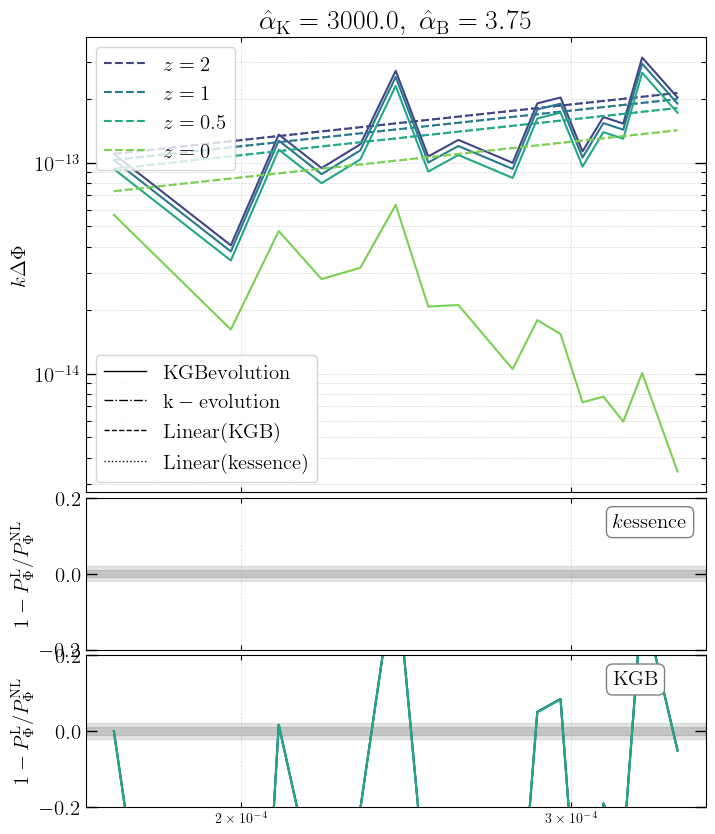

In [49]:
fig, ax = plt.subplots(
    3, 1, gridspec_kw={"height_ratios": [3, 1,1]}, figsize=(8, 10), sharex=True
)
plt.subplots_adjust(hspace=0.022, wspace=0.23)


#c = sns.color_palette("viridis", len(z)).as_hex()

plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 18}

# simulation
k_zp     = dict(zip(z, final['k']))
phi_zp = dict(zip(z, final['phi']))




# hiclass
Pk_phi_kgb_zp  = dict(zip(z, Pk_phi_kgb))
Pk_phi_kess_zp = dict(zip(z, Pk_phi_kess))



# 2) Choose the redshifts you actually want to plot
target_z = [ 2, 1, 0.5, 0]

colors = sns.color_palette("viridis", len(target_z)).as_hex()



for c, zv in zip(colors, target_z):
    
    # simulation
    k_vals     = k_zp[zv]
    phi_vals = k_vals*h*phi_zp[zv]

    
    # hiclass
    Pk_phi_kgb_vals = Pk_phi_kgb_zp[zv]
    Pk_phi_kess_vals = Pk_phi_kess_zp[zv]
    

    #############################################################################
    #                                         hiclass
    
    
    ax[0].plot(
        k_vals,
        Pk_phi_kgb_vals,"--",
        label=f"$z={zv}$",
        c = c,
        alpha = 1,
        markersize=6
    )
    
    
    ax[0].plot(
        k_vals,
        Pk_phi_kess_vals,":",
        c = c,
        markersize=6
    )
    
    
    #############################################################################
    #                                         KGB-evolution
    if show_sim_plots:
        

    
    
        ax[0].plot(
            k_vals,
            phi_vals,"-",
            c = c,
            alpha =1,
            markersize=6
        )
    
    
    
    
    
    ##############################################################################
    #                                         Rel Diff
    

    
    ax[2].plot(
        kk,
        (1-np.array(Pk_phi_kgb_vals)/phi_vals),"-",
        c = c,
        markersize=6
    )


    
    

linestyles = ["-","-.", "--", ":"]
lines = [Line2D([0], [0], color="black", linewidth=1, linestyle=l) for l in linestyles]
labels = [f"$\mathrm{{KGBevolution}}$ ", f"$\mathrm{{k-evolution}}$ ",f"$\mathrm{{Linear(KGB)}}$", f"$\mathrm{{Linear(kessence)}}$"]



leg2 = ax[0].legend(lines, labels, loc="lower left", fontsize=15)

ax[0].add_artist(leg2)

ax[0].legend(fontsize=15)    
    
    
for i in range (1,3):
    ax[i].set_ylim(-0.2,0.2)

    ax[i].axhspan(-0.01, 0.01, color="gray", alpha=0.3)
    ax[i].axhspan(-0.02, 0.02, color="gray", alpha=0.2)

for i in range(3):
    ax[i].set_xscale("log")
    

    # plt.xlim(5.0e-5, 0.01)
    # plt.ylim(1.e-17,3.e-9)
    ax[i].grid(which="both", axis="both", linestyle="--", linewidth=0.5, alpha = 0.5)


    ax[i].tick_params("both", length=8, width=1, which="major")
    ax[i].tick_params("both", length=3.5, width=0.8, which="minor")
    ax[i].tick_params(direction="in", which="major", labelsize=15)
    ax[i].tick_params(direction="in", which="minor")
    ax[i].yaxis.set_ticks_position("both")
    ax[i].xaxis.set_ticks_position("both")


ax[0].set_yscale("log")
ax[0].set_ylabel(r"$k\Delta\Phi$", fontsize=15)
ax[1].set_ylabel(r"$1-P_{\Phi}^\mathrm{L}/P_{\Phi}^\mathrm{NL}$", fontsize=15)
ax[2].set_ylabel(r"$1-P_{\Phi}^\mathrm{L}/P_{\Phi}^\mathrm{NL}$", fontsize=15)
ax[1].set_xlabel("$k~ [h/\mathrm{Mpc}]$", fontsize=15)



ax[1].text(.85, 0.9, r'$k\mathrm{essence}$',
           transform=ax[1].transAxes,
           fontsize=15, ha='left', va='top',
           bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))
ax[2].text(0.85, 0.9, r'$\mathrm{KGB}$',
           transform=ax[2].transAxes,
           fontsize=15, ha='left', va='top',
           bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

ax[0].legend(
    fontsize=15,  # Font size
    loc="upper left",  # Place legend above the plot
#     bbox_to_anchor=(1.23, 1.03),  # Position outside plot area (x, y relative to axes)
#     ncol=1,  # Number of columns
)





ax[0].set_title(
    rf"$\hat{{\alpha}}_{{\mathrm{{K}}}} = {alpha_K_hat},\ \hat{{\alpha}}_{{\mathrm{{B}}}} = {alpha_B_hat}$",
    fontsize=20,
)


plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 15}

#save_fig("matter_power_spectrum")

# Dark energy power spectrum

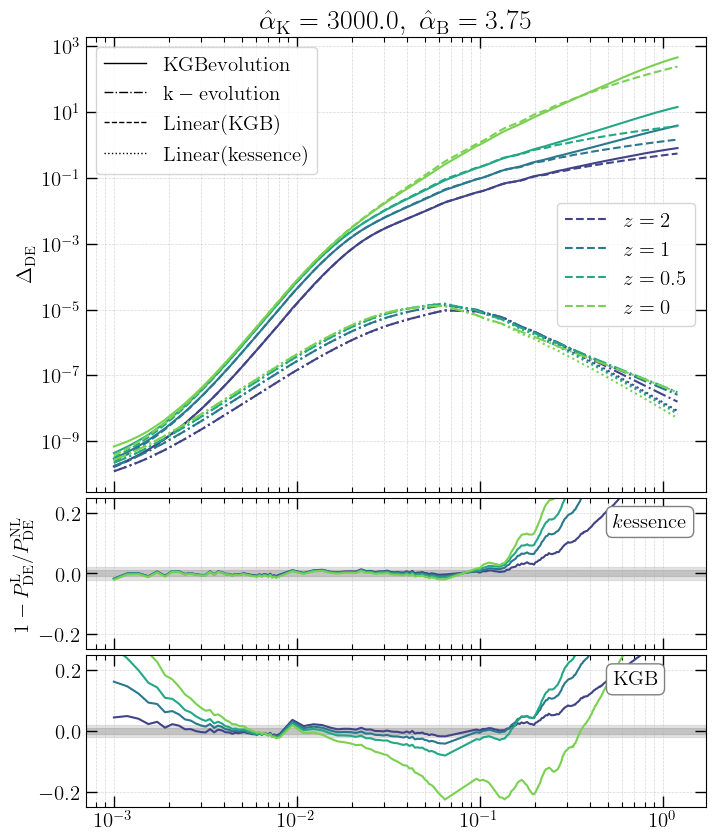

In [68]:
fig, ax = plt.subplots(
    3, 1, gridspec_kw={"height_ratios": [3, 1,1]}, figsize=(8, 10), sharex=True
)
plt.subplots_adjust(hspace=0.022, wspace=0.23)


#c = sns.color_palette("viridis", len(z)).as_hex()

plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 18}

# simulation
k_zp     = dict(zip(z, final['k']))
delta_kgb_zp = dict(zip(z, final['delta_kgb']))

# simulation kessence
delta_kess_zp = dict(zip(z, final_kess['delta_kgb']))


# hiclass
Pk_smg_kgb_zp  = dict(zip(z, Pk_smg_kgb))
Pk_smg_kess_zp = dict(zip(z, Pk_smg_kess))


# 2) Choose the redshifts you actually want to plot
target_z = [ 2, 1, 0.5, 0]

colors = sns.color_palette("viridis", len(target_z)).as_hex()



for c, zv in zip(colors, target_z):
    
    # simulation
    k_vals     = k_zp[zv]
    delta_kgb_vals = delta_kgb_zp[zv]
    delta_kess_vals = delta_kess_zp[zv]
    
    # hiclass
    Pk_smg_kgb_vals =Pk_smg_kgb_zp[zv]
    Pk_smg_kess_vals =Pk_smg_kess_zp[zv]
    

    #############################################################################
    #                                         hiclass
    
    
    ax[0].plot(
        k_vals,
        Pk_smg_kgb_vals,"--",
        label=f"$z={zv}$",
        c = c,
        alpha = 1,
        markersize=6
    )
    
    
    ax[0].plot(
        k_vals,
        Pk_smg_kess_vals,":",
        c = c,
        markersize=6
    )
    
    
    #############################################################################
    #                                         KGB-evolution
    if show_sim_plots:
        
        ax[0].plot(
            k_vals,
            delta_kess_vals,"-.",
            c = c,
            alpha =1,
            markersize=6
        )

    
        ax[0].plot(
            k_vals,
            delta_kgb_vals,"-",
            c = c,
            alpha =1,
            markersize=6
        )

    
    
    
    
    ##############################################################################
    #                                         Rel Diff
    
    ax[1].plot(
        kk,
        (1-np.array(Pk_smg_kess_vals)/delta_kess_vals),"-",
        c = c,
        markersize=6
    )
    
    ax[2].plot(
        kk,
        (1-np.array(Pk_smg_kgb_vals)/delta_kgb_vals),"-",
        c = c,
        markersize=6
    )


    
linestyles = ["-","-.", "--", ":"]
lines = [Line2D([0], [0], color="black", linewidth=1, linestyle=l) for l in linestyles]
labels = [f"$\mathrm{{KGBevolution}}$ ", f"$\mathrm{{k-evolution}}$ ",f"$\mathrm{{Linear(KGB)}}$", f"$\mathrm{{Linear(kessence)}}$"]



leg2 = ax[0].legend(lines, labels, loc="upper left", fontsize=15)

ax[0].add_artist(leg2)

ax[0].legend(fontsize=15)    
    
    
for i in range (1,3):
    ax[i].set_ylim(-0.25,0.25)

    ax[i].axhspan(-0.01, 0.01, color="gray", alpha=0.3)
    ax[i].axhspan(-0.02, 0.02, color="gray", alpha=0.2)

for i in range(3):
    ax[i].set_xscale("log")
    

    # plt.xlim(5.0e-5, 0.01)
    # plt.ylim(1.e-17,3.e-9)
    ax[i].grid(which="both", axis="both", linestyle="--", linewidth=0.5, alpha = 0.5)


    ax[i].tick_params("both", length=8, width=1, which="major")
    ax[i].tick_params("both", length=3.5, width=0.8, which="minor")
    ax[i].tick_params(direction="in", which="major", labelsize=15)
    ax[i].tick_params(direction="in", which="minor")
    ax[i].yaxis.set_ticks_position("both")
    ax[i].xaxis.set_ticks_position("both")


ax[0].set_yscale("log")
ax[0].set_ylabel(r"$\Delta_\mathrm{DE}$", fontsize=15)
ax[1].set_ylabel(r"$1-P_\mathrm{DE}^\mathrm{L}/P_\mathrm{DE}^\mathrm{NL}$", fontsize=15)
ax[1].set_xlabel("$k~ [h/\mathrm{Mpc}]$", fontsize=15)


ax[1].text(.85, 0.9, r'$k\mathrm{essence}$',
           transform=ax[1].transAxes,
           fontsize=15, ha='left', va='top',
           bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))
ax[2].text(0.85, 0.9, r'$\mathrm{KGB}$',
           transform=ax[2].transAxes,
           fontsize=15, ha='left', va='top',
           bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

ax[0].legend(
    fontsize=15,  # Font size
    loc="center right",  # Place legend above the plot
#     bbox_to_anchor=(1.23, 1.03),  # Position outside plot area (x, y relative to axes)
#     ncol=1,  # Number of columns
)





ax[0].set_title(
    rf"$\hat{{\alpha}}_{{\mathrm{{K}}}} = {alpha_K_hat},\ \hat{{\alpha}}_{{\mathrm{{B}}}} = {alpha_B_hat}$",
    fontsize=20,
)


plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 15}

#save_fig("matter_power_spectrum")

# $\pi$ power spectra

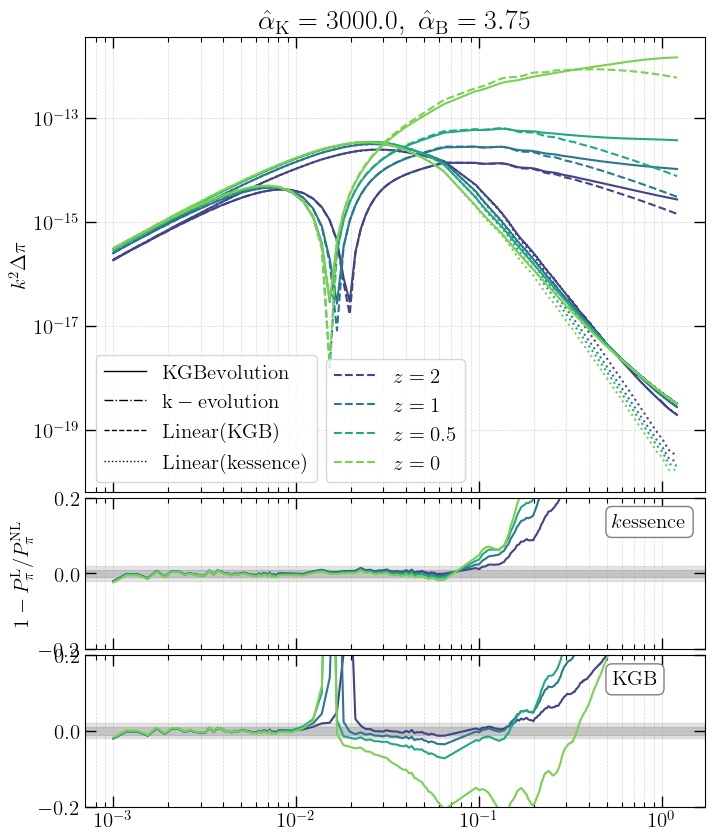

In [74]:
fig, ax = plt.subplots(
    3, 1, gridspec_kw={"height_ratios": [3, 1, 1]}, figsize=(8, 10), sharex=True
)
plt.subplots_adjust(hspace=0.022, wspace=0.23)


#c = sns.color_palette("viridis", len(z)).as_hex()

plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 18}

# simulation
k_zp     = dict(zip(z, final['k']))
pi_k_zp = dict(zip(z, final['pi_k']))

# simulation kessence
pi_k_kess_zp = dict(zip(z, final_kess['pi_k']))


# hiclass
Pk_pi_k_kgb_zp  = dict(zip(z, Pk_pi_k_kgb))
Pk_pi_k_kess_zp = dict(zip(z, Pk_pi_k_kess))



# 2) Choose the redshifts you actually want to plot
target_z = [2, 1, 0.5, 0]

colors = sns.color_palette("viridis", len(target_z)).as_hex()



for c, zv in zip(colors, target_z):
    
    # simulation
    k_vals     = k_zp[zv]
    pi_k_vals = k_vals*h*k_vals*h*pi_k_zp[zv]
    pi_k_kess_vals = k_vals*h*k_vals*h*pi_k_kess_zp[zv]
    
    # hiclass
    Pk_pi_k_kgb_vals = Pk_pi_k_kgb_zp[zv]
    Pk_pi_k_kess_vals = Pk_pi_k_kess_zp[zv]
    

    #############################################################################
    #                                         hiclass
    
    
    ax[0].plot(
        k_vals,
        Pk_pi_k_kgb_vals,"--",
        label=f"$z={zv}$",
        c = c,
        alpha = 1,
        markersize=6
    )
    
    
    ax[0].plot(
        k_vals,
        Pk_pi_k_kess_vals,":",
        c = c,
        markersize=6
    )
    
    
    #############################################################################
    #                                         KGB-evolution
    
    if show_sim_plots:
        
        ax[0].plot(
            k_vals,
            pi_k_kess_vals,"-,",
            c = c,
            alpha =1,
            markersize=6
        )
        
        ax[0].plot(
            k_vals,
            pi_k_vals,"-",
            c = c,
            alpha =1,
            markersize=6
        )
    
    
    
    
    
    ##############################################################################
    #                                         Rel Diff
    
    ax[1].plot(
        kk,
        (1-np.array(Pk_pi_k_kess_vals)/pi_k_kess_vals),"-",
        c = c,
        markersize=6
    )

    ax[2].plot(
        kk,
        (1-np.array(Pk_pi_k_kgb_vals)/pi_k_vals),"-",
        c = c,
        markersize=6
    )


    
    
linestyles = ["-","-.", "--", ":"]
lines = [Line2D([0], [0], color="black", linewidth=1, linestyle=l) for l in linestyles]
labels = [f"$\mathrm{{KGBevolution}}$ ", f"$\mathrm{{k-evolution}}$ ",f"$\mathrm{{Linear(KGB)}}$", f"$\mathrm{{Linear(kessence)}}$"]



leg2 = ax[0].legend(lines, labels, loc="lower left", fontsize=15)

ax[0].add_artist(leg2)

ax[0].legend(fontsize=15)    
    
    

for i in range (1,3):
    ax[i].set_ylim(-0.2,0.2)

    ax[i].axhspan(-0.01, 0.01, color="gray", alpha=0.3)
    ax[i].axhspan(-0.02, 0.02, color="gray", alpha=0.2)

for i in range(3):
    ax[i].set_xscale("log")
    

    # plt.xlim(5.0e-5, 0.01)
    # plt.ylim(1.e-17,3.e-9)
    ax[i].grid(which="both", axis="both", linestyle="--", linewidth=0.5, alpha = 0.5)


    ax[i].tick_params("both", length=8, width=1, which="major")
    ax[i].tick_params("both", length=3.5, width=0.8, which="minor")
    ax[i].tick_params(direction="in", which="major", labelsize=15)
    ax[i].tick_params(direction="in", which="minor")
    ax[i].yaxis.set_ticks_position("both")
    ax[i].xaxis.set_ticks_position("both")


ax[0].set_yscale("log")
ax[0].set_ylabel(r"$k^2\Delta\pi$", fontsize=15)
ax[1].set_ylabel(r"$1-P_{\pi}^\mathrm{L}/P_{\pi}^\mathrm{NL}$", fontsize=15)
ax[1].set_xlabel("$k~ [h/\mathrm{Mpc}]$", fontsize=15)


ax[1].text(.85, 0.9, r'$k\mathrm{essence}$',
           transform=ax[1].transAxes,
           fontsize=15, ha='left', va='top',
           bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))
ax[2].text(0.85, 0.9, r'$\mathrm{KGB}$',
           transform=ax[2].transAxes,
           fontsize=15, ha='left', va='top',
           bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

ax[0].legend(
    fontsize=15,  # Font size
    loc="lower center",  # Place legend above the plot
#     bbox_to_anchor=(1.23, 1.03),  # Position outside plot area (x, y relative to axes)
#     ncol=1,  # Number of columns
)





ax[0].set_title(
    rf"$\hat{{\alpha}}_{{\mathrm{{K}}}} = {alpha_K_hat},\ \hat{{\alpha}}_{{\mathrm{{B}}}} = {alpha_B_hat}$",
    fontsize=20,
)


plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 15}

#save_fig("matter_power_spectrum")

# $\zeta$ power spectra

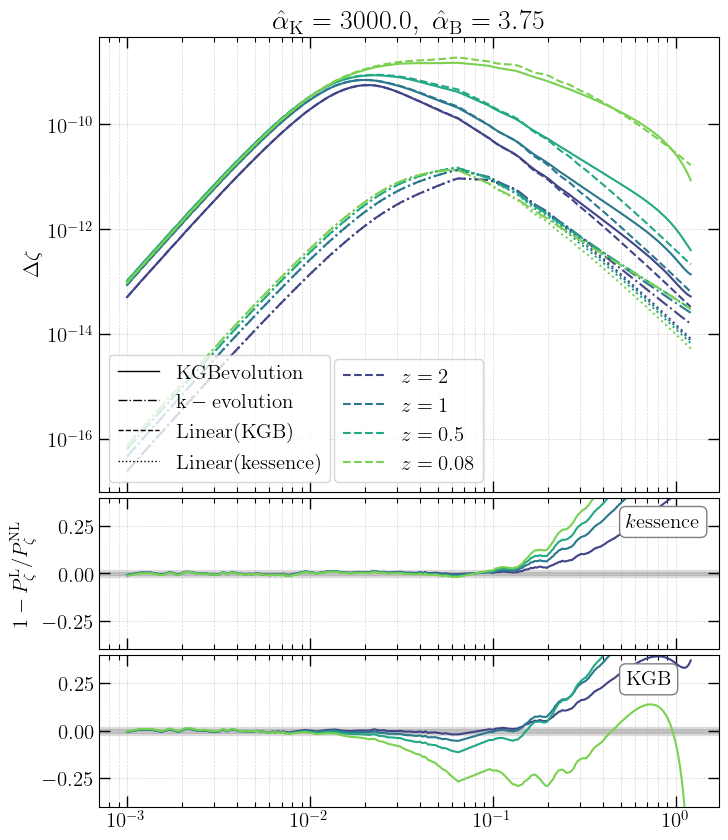

In [76]:
fig, ax = plt.subplots(
    3, 1, gridspec_kw={"height_ratios": [3, 1,1]}, figsize=(8, 10), sharex=True
)
plt.subplots_adjust(hspace=0.022, wspace=0.23)


#c = sns.color_palette("viridis", len(z)).as_hex()

plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 18}

# simulation
k_zp     = dict(zip(z, final['k']))
zeta_zp = dict(zip(z, final['zeta']))

# simulation kessence
zeta_kess_zp = dict(zip(z, final_kess['zeta']))


# hiclass
Pk_zeta_kgb_zp  = dict(zip(z, Pk_zeta_kgb))
Pk_zeta_kess_zp = dict(zip(z, Pk_zeta_kess))



# 2) Choose the redshifts you actually want to plot
target_z = [2, 1, 0.5, 0.08]

colors = sns.color_palette("viridis", len(target_z)).as_hex()



for c, zv in zip(colors, target_z):
    
    # simulation
    k_vals     = k_zp[zv]
    zeta_vals = zeta_zp[zv]
    zeta_kess_vals = zeta_kess_zp[zv]
    
    # hiclass
    Pk_zeta_kgb_vals = Pk_zeta_kgb_zp[zv]
    Pk_zeta_kess_vals = Pk_zeta_kess_zp[zv]
    

    #############################################################################
    #                                         hiclass
    
    
    ax[0].plot(
        k_vals,
        Pk_zeta_kgb_vals,"--",
        label=f"$z={zv}$",
        c = c,
        alpha = 1,
        markersize=6
    )
    
    
    ax[0].plot(
        k_vals,
        Pk_zeta_kess_vals,":",
        c = c,
        markersize=6
    )
    
    
    #############################################################################
    #                                         KGB-evolution
    
    if show_sim_plots:
        
        ax[0].plot(
            k_vals,
            zeta_kess_vals,"-.",
            c = c,
            alpha =1,
            markersize=6
        )
        
        ax[0].plot(
            k_vals,
            zeta_vals,"-",
            c = c,
            alpha =1,
            markersize=6
        )

    
    
    
    
    ##############################################################################
    #                                         Rel Diff
    
    ax[1].plot(
        kk,
        (1-np.array(Pk_zeta_kess_vals)/zeta_kess_vals),"-",
        c = c,
        markersize=6
    )
    
    ax[2].plot(
        kk,
        (1-np.array(Pk_zeta_kgb_vals)/zeta_vals),"-",
        c = c,
        markersize=6
    )


    
    

linestyles = ["-","-.", "--", ":"]
lines = [Line2D([0], [0], color="black", linewidth=1, linestyle=l) for l in linestyles]
labels = [f"$\mathrm{{KGBevolution}}$ ", f"$\mathrm{{k-evolution}}$ ",f"$\mathrm{{Linear(KGB)}}$", f"$\mathrm{{Linear(kessence)}}$"]



leg2 = ax[0].legend(lines, labels, loc="lower left", fontsize=15)

ax[0].add_artist(leg2)

ax[0].legend(fontsize=15)    
    
    

for i in range (1,3):
    ax[i].set_ylim(-0.4,0.4)

    ax[i].axhspan(-0.01, 0.01, color="gray", alpha=0.3)
    ax[i].axhspan(-0.02, 0.02, color="gray", alpha=0.2)

for i in range(3):
    ax[i].set_xscale("log")
    

    # plt.xlim(5.0e-5, 0.01)
    # plt.ylim(1.e-17,3.e-9)
    ax[i].grid(which="both", axis="both", linestyle="--", linewidth=0.5, alpha = 0.5)


    ax[i].tick_params("both", length=8, width=1, which="major")
    ax[i].tick_params("both", length=3.5, width=0.8, which="minor")
    ax[i].tick_params(direction="in", which="major", labelsize=15)
    ax[i].tick_params(direction="in", which="minor")
    ax[i].yaxis.set_ticks_position("both")
    ax[i].xaxis.set_ticks_position("both")


ax[0].set_yscale("log")
ax[0].set_ylabel(r"$\Delta\zeta$", fontsize=15)
ax[1].set_ylabel(r"$1-P_{\zeta}^\mathrm{L}/P_{\zeta}^\mathrm{NL}$", fontsize=15)
ax[1].set_xlabel("$k~ [h/\mathrm{Mpc}]$", fontsize=15)

ax[1].text(.85, 0.9, r'$k\mathrm{essence}$',
           transform=ax[1].transAxes,
           fontsize=15, ha='left', va='top',
           bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))
ax[2].text(0.85, 0.9, r'$\mathrm{KGB}$',
           transform=ax[2].transAxes,
           fontsize=15, ha='left', va='top',
           bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))


ax[0].legend(
    fontsize=15,  # Font size
    loc="lower center",  # Place legend above the plot
#     bbox_to_anchor=(1.23, 1.03),  # Position outside plot area (x, y relative to axes)
#     ncol=1,  # Number of columns
)





ax[0].set_title(
    rf"$\hat{{\alpha}}_{{\mathrm{{K}}}} = {alpha_K_hat},\ \hat{{\alpha}}_{{\mathrm{{B}}}} = {alpha_B_hat}$",
    fontsize=20,
)


plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 15}

#save_fig("matter_power_spectrum")

# $w(z)$

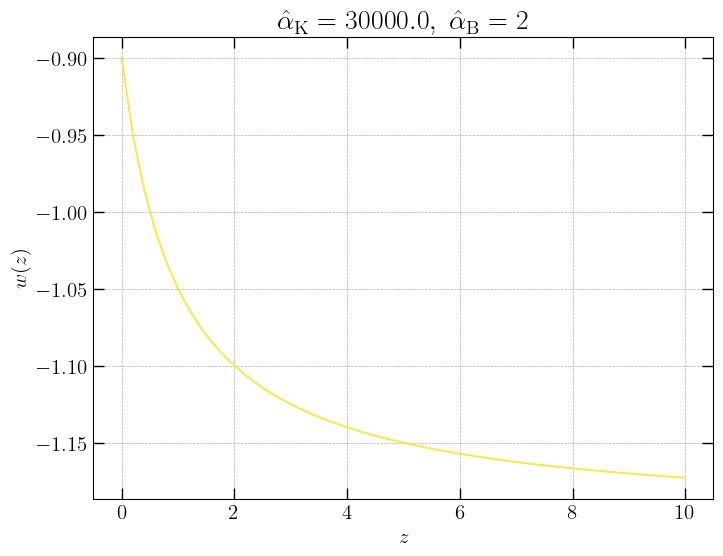

In [13]:
fig, ax = plt.subplots(
    1, 1, figsize=(8, 6), sharex=True
)
plt.subplots_adjust(hspace=0.022, wspace=0.23)


c = sns.color_palette("viridis", len(z)).as_hex()

plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 18}

#z = list(range(10, -1, -1))
z = list(np.arange(10, -0.001, -0.2))


ax.plot(
    z,
    p_smg(z)/rho_smg(z),"-",
    c = c[zind],
    #label="hiclass_kgb, $z=$" + str(z[zind]),
    alpha = 0.8,
    markersize=6
)


ax.grid(which="both", axis="both", linestyle="--", linewidth=0.5)
ax.tick_params("both", length=8, width=1, which="major")
ax.tick_params("both", length=3.5, width=0.8, which="minor")
ax.tick_params(direction="in", which="major", labelsize=15)
ax.tick_params(direction="in", which="minor")
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")


#ax[0].set_yscale("log")
ax.set_ylabel(r"$w(z)$", fontsize=15)
#ax[1].set_ylabel(r"$1-P_\mathrm{kess}/P_\mathrm{kgb}~ [\%]$", fontsize=15)
ax.set_xlabel("$z$", fontsize=15)


ax.set_title(
    rf"$\hat{{\alpha}}_{{\mathrm{{K}}}} = {alpha_K_hat},\ \hat{{\alpha}}_{{\mathrm{{B}}}} = {alpha_B_hat}$",
    fontsize=20,
)


plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 15}


In [ ]:
# from configparser import ConfigParser
# from itertools import chain

# ############################################################################################################ 
# #                                               data path

# #folder_name_kgb = '/home/ahmad/kgb-master/output'
# folder_name_kgb = '/home/ahmad/kgb-master/data/3072-90000/'
# #folder_name_kgb = '/home/ahmad/kgb-master/data/2048-800/'


# ############################################################################################################ 
# #                                              background file


# with open(f"{folder_name_kgb}/file_background.dat") as f:
#     lines = f.readlines()

# fourpiG_val = float(next(line.split("=")[1].strip() for line in lines if line.startswith("# fourpiG")))
# H0_val = float(next(line.split("=")[1].strip() for line in lines if line.startswith("# H0[1/Mpc]")))

# norm_kgb = np.sqrt(2*fourpiG_val/3)/H0_val

# bg_kgb = np.loadtxt(f"{folder_name_kgb}/file_background.dat")

# # scale factor and redshift
# a_kgb = bg_kgb[:,2]
# z_kgb = bg_kgb[:,3]

# # z_kgb = [0 if x < 0 else x for x in z_kgb]
# # z_kgb[-2], z_kgb[-1] = 0.01, 0


# # Conformal Hubble parameter and its derivative 
# Hconf_kgb = bg_kgb[:,5]
# Hconf_prime_kgb = bg_kgb[:,6]
# Hconf_prime_prime_kgb = bg_kgb[:,7]


# # alpha parameters and their derivatives
# alpha_K_kgb = bg_kgb[:,17]
# alpha_B_kgb = bg_kgb[:,18]
# alpha_K_prime_kgb = bg_kgb[:,19]
# alpha_B_prime_kgb = bg_kgb[:,20]

# # dark energy density and pressure and their derivatives
# rho_smg_kgb = bg_kgb[:,13]
# p_smg_kgb = bg_kgb[:,14]
# rho_smg_prime_kgb = bg_kgb[:,15]
# p_smg_prime_kgb = bg_kgb[:,16]
# cs2_kgb = bg_kgb[:,21]

# H_hiclass =  bg_kgb[:,4]

# # other background values
# rho_cdm_kgb = bg_kgb[:,8]
# rho_b_kgb = bg_kgb[:,9]

# ############################################################################################################ 
# #                                         hiclass ini parameters

# parser = ConfigParser()
# with open(f"{folder_name_kgb}/file_classparameters.ini") as lines:
#     lines = chain(("[top]",), lines) # This line produce a fake section header called top
#     parser.read_file(lines)

# Omega_fld = float(parser.get("top", "Omega_fld"))
# Omega_Lambda = float(parser.get("top", "Omega_Lambda"))
# Omega_smg= float(parser.get("top", "Omega_smg"))

# Omega_b = float(parser.get("top", "Omega_b"))
# Omega_cdm = float(parser.get("top", "Omega_cdm"))
# Omega_g = float(parser.get("top", "Omega_g"))
# Omega_ur = float(parser.get("top", "Omega_ur"))

# # Extract and parse the 'parameters_smg' string
# expansion_smg_str = parser.get("top", "expansion_smg")
# expansion_smg_list = expansion_smg_str.split(',')
# Omega_kgb = float(expansion_smg_list[0].strip())

# expansion_model_str = parser.get("top", "expansion_model")

# ############################################################################################################ 
# #                                   KGB-evolution used.ini parameters

# with open(f"{folder_name_kgb}/file_settings_used.ini") as lines:
#     lines = chain(("[top]",), lines) # This line produce a fake section header called top
#     parser.read_file(lines)

# k_pivot = float(parser.get("top", "k_pivot"))     
# A_s = float(parser.get("top", "A_s"))   
# n_s = float(parser.get("top", "n_s"))
# h = float(parser.get("top", "h"))

# omega_b = float(parser.get("top", "omega_b"))
# omega_cdm = float(parser.get("top", "omega_cdm"))


# gravity_model = (parser.get("top", "gravity_model"))
    
# # Extract and parse the 'parameters_smg' string
# parameters_smg_str = parser.get("top", "parameters_smg")
# parameters_smg_list = parameters_smg_str.split(',')
    
# # Convert the first two parameters to floats
# alpha_K_hat = float(parameters_smg_list[0].strip())
# alpha_B_hat = float(parameters_smg_list[1].strip())    



# # Function to format numbers for LaTeX (reusing the previous function)
# def format_scientific_latex(number):
#     mantissa, exponent = f"{number:.1e}".split('e')
#     exponent = exponent.lstrip('+').lstrip('0') or '0'
#     return f"{mantissa} \\times 10^{{{exponent}}}"

# # Format the alpha values
# alpha_K_hat_latex = format_scientific_latex(alpha_K_hat)

# # Extract and parse the 'parameters_smg' string
# expansion_smg_str = parser.get("top", "expansion_smg")
# expansion_smg_list = expansion_smg_str.split(',')

# w_kgb = float(expansion_smg_list[0].strip())
# w_a_kgb = float(expansion_smg_list[1].strip())

# boxsize = float(parser.get("top", "boxsize"))
# Ngrid = float(parser.get("top", "Ngrid"))

# boxsize = int(boxsize)
# Ngrid = int(Ngrid)

# # z_snap = float(parser.get("top", "snapshot redshifts"))
# # a_snap = 1/(1+z_snap)

# k_nyq = np.pi*Ngrid/boxsize
# dx = boxsize/Ngrid

# n_kgb_numsteps   = float(parser.get("top", "n_kgb_numsteps"))
# Courant_factor = float(parser.get("top", "Courant factor"))


# Omega_Lambda = float(parser.get("top", "Omega_Lambda"))

# # reading Pk the redshifts
# z = []

# with open(f'{folder_name_kgb}/file_settings_used.ini', 'r') as f:
#     for line in f:
#         if line.startswith('Pk redshifts'):
#             # Extract the part after '=' and split by commas
#             redshifts_string = line.split('=')[1].split('#')[0].strip()  # Remove comments after #
#             z = [float(x.strip()) for x in redshifts_string.split(',')]  # Parse as floats

# redshifts = z

# colors_plot = sns.color_palette("inferno", len(z)).as_hex()


# delta_rho_kgb = [None] * len(z)
# mu = [None] * len(z)
# mu_corr =[None] * len(z)

# pk_phi_kgb = [None] * len(z)
# pk_phi_prime_kgb = [None] * len(z)

# pk_matter_kgb = [None] * len(z)
# pk_pi_kgb = [None] * len(z)
# pk_zeta_kgb = [None] * len(z)

# f_rho_fld = interp1d(z_kgb, rho_smg_kgb, kind='linear')
# f_rho_cdm = interp1d(z_kgb, rho_cdm_kgb, kind='linear')
# f_rho_b = interp1d(z_kgb, rho_b_kgb, kind='linear')


# def rho_m_kgb_f(val):
#     return f_rho_cdm(val) + f_rho_b(val)

# def rho_smg_kgb_f(val):
#     return f_rho_fld(val)

# for zind, zval in list(enumerate(z)):
    
#     file_index = str(zind).zfill(2)
    
#     data_kgb["kgb"]["delta_kgb"]["z=" + str(z[zind])] = np.loadtxt(
#         f"{folder_name_kgb}/pk_0{file_index}_delta_kgb.dat"
#     )
#     data_kgb["kgb"]["delta"]["z=" + str(z[zind])] = np.loadtxt(
#         f"{folder_name_kgb}/pk_0{file_index}_delta.dat"
#     )
    
#     data_kgb["kgb"]["phi"]["z=" + str(z[zind])] = np.loadtxt(
#         f"{folder_name_kgb}/pk_0{file_index}_phi.dat"
#     )
    
#     data_kgb["kgb"]["phi_prime"]["z=" + str(z[zind])] = np.loadtxt(
#         f"{folder_name_kgb}/pk_0{file_index}_phi_prime.dat"
#     )
    
#     data_kgb["kgb"]["pi"]["z=" + str(z[zind])] = np.loadtxt(
#         f"{folder_name_kgb}/pk_0{file_index}_pi_k.dat"
#     )
    
#     data_kgb["kgb"]["zeta"]["z=" + str(z[zind])] = np.loadtxt(
#         f"{folder_name_kgb}/pk_0{file_index}_zeta.dat"
#     )
#     data_kgb["kgb"]["deltakgb_deltam"]["z=" + str(z[zind])] = np.loadtxt(
#         f"{folder_name_kgb}/pk_0{file_index}_deltakgb_deltam.dat"
#     )
    
#     k = data_kgb["kgb"]["delta_kgb"]["z=" + str(z[zind])][:, 0]
    
#     pk_kgb_delta_kgb = data_kgb["kgb"]["delta_kgb"]["z=" + str(z[zind])][:, 1]

#     pk_kgb_delta = data_kgb["kgb"]["delta"]["z=" + str(z[zind])][:, 1]
    
#     pk_kgb_phi = data_kgb["kgb"]["phi"]["z=" + str(z[zind])][:, 1]
    
#     pk_kgb_phi_prime = data_kgb["kgb"]["phi_prime"]["z=" + str(z[zind])][:, 1]
    
#     pk_kgb_pi = data_kgb["kgb"]["pi"]["z=" + str(z[zind])][:, 1]
    
#     pk_kgb_zeta = data_kgb["kgb"]["zeta"]["z=" + str(z[zind])][:, 1]
    
#     pk_kgb_deltakgb_deltam = data_kgb["kgb"]["deltakgb_deltam"]["z=" + str(z[zind])][:, 1]
    
#     norm = (2*(np.pi)**2)/((k)**3)
    
#     delta_rho_kgb[zind] = pk_kgb_delta_kgb 
#     pk_phi_kgb[zind] = pk_kgb_phi
#     pk_phi_prime_kgb[zind] = pk_kgb_phi_prime
#     pk_matter_kgb[zind] = pk_kgb_delta * norm
    
#     pk_pi_kgb[zind] = pk_kgb_pi
#     pk_zeta_kgb[zind] = pk_kgb_zeta
    
    
    
    
#     mu[zind] = 1 + (rho_smg_kgb_f(zval)*np.sqrt(pk_kgb_delta_kgb))/(rho_m_kgb_f(zval)*np.sqrt(pk_kgb_delta))
#     mu_corr[zind] = np.sqrt(
#     ((rho_smg_kgb_f(zval) ** 2) * pk_kgb_delta_kgb + (rho_m_kgb_f(zval) ** 2) * pk_kgb_delta
#         + 2 * (rho_m_kgb_f(zval) * rho_smg_kgb_f(zval)) * pk_kgb_deltakgb_deltam)
#     / ((rho_m_kgb_f(zval) ** 2) * pk_kgb_delta)
#     )
#     #kk_kgb = k
    
#     ind_nyq       = [i for i, v in enumerate(k) if k_nyq*0.75 < v ][0]
#     #ind_nyq =-1
#     kk_kgb        = k[:ind_nyq]
    
#     mu[zind]      = mu[zind][:ind_nyq]
#     delta_rho_kgb[zind]  =  delta_rho_kgb[zind][:ind_nyq]
    
#     pk_phi_kgb[zind] = pk_phi_kgb[zind][:ind_nyq]
#     pk_phi_prime_kgb[zind] = pk_phi_prime_kgb[zind][:ind_nyq]
#     pk_matter_kgb[zind] =pk_matter_kgb[zind][:ind_nyq]
#     pk_pi_kgb[zind] =  pk_pi_kgb[zind][:ind_nyq]
#     pk_zeta_kgb[zind] = pk_zeta_kgb[zind][:ind_nyq]
    
#     mu_corr[zind] = mu_corr[zind][:ind_nyq]

# $\Lambda$CDM

In [ ]:
# delta_smg_CLASS = [None] * len(z)

# LCDM_settings ={
#         "Omega_scf": 0,
#         "Omega_Lambda": 0,
#         "cs2_fld": 1e-7,
#         "w0_fld": -1,
#         "wa_fld":0,
#         "h": 0.67556,
#         "omega_b": 0.022032,
#         "omega_cdm": 0.12038,
#         "A_s": 2.215e-9,
#         "n_s": 0.9619,
#         "z_max_pk": 100,
#         "tau_reio": 0.05430842,
#         "N_ur":3.046,
#         "gauge":"Newtonian",
#         "output": "vTk,mTk,mPk",
#         "use_ppf":"yes",
#         "P_k_max_1/Mpc": 192,
#     }

# M_LCDM = Class()
# M_LCDM.set(LCDM_settings)
# M_LCDM.compute()


# backgrounds = M_LCDM.get_background()

# rho_b = interp1d(backgrounds["z"], backgrounds["(.)rho_b"], kind="cubic")
# rho_cdm = interp1d(backgrounds["z"], backgrounds["(.)rho_cdm"], kind="cubic")
# rho_g = interp1d(backgrounds["z"], backgrounds["(.)rho_g"], kind="cubic")
# rho_ur = interp1d(backgrounds["z"], backgrounds["(.)rho_ur"], kind="cubic")
# rho_tot = interp1d(backgrounds["z"], backgrounds["(.)rho_tot"], kind="cubic")
# rho_crit = interp1d(backgrounds["z"], backgrounds["(.)rho_crit"], kind="cubic")

# H = interp1d(backgrounds["z"], backgrounds["H [1/Mpc]"], kind="cubic")
# H_prime = interp1d(backgrounds["z"], backgrounds["H_prime"], kind="cubic")


# rho_fld = interp1d(backgrounds["z"], backgrounds["(.)rho_fld"], kind="cubic")
# w_fld = interp1d(backgrounds["z"], backgrounds["(.)w_fld"], kind="cubic")

# for zind, z_val in enumerate(z):

#     Transfers_CLASS = M_LCDM.get_transfer(z_val)

#     #############
#     delta_b_CLASS = interp1d(
#         Transfers_CLASS["k (h/Mpc)"], Transfers_CLASS["d_b"], kind="cubic"
#     )
#     theta_b_CLASS = interp1d(
#         Transfers_CLASS["k (h/Mpc)"], Transfers_CLASS["t_b"], kind="cubic"
#     )
#     #############
#     #                         theta_cdm is zero in synchronous gauge
#     delta_cdm_CLASS = interp1d(
#         Transfers_CLASS["k (h/Mpc)"], Transfers_CLASS["d_cdm"], kind="cubic"
#     )
#     #############
#     delta_fld_CLASS = interp1d(
#         Transfers_CLASS["k (h/Mpc)"], Transfers_CLASS["d_fld"], kind="cubic"
#     )
#     theta_fld_CLASS = interp1d(
#         Transfers_CLASS["k (h/Mpc)"], Transfers_CLASS["t_fld"], kind="cubic"
#     )
#     #############
#     delta_g_CLASS = interp1d(
#         Transfers_CLASS["k (h/Mpc)"], Transfers_CLASS["d_g"], kind="cubic"
#     )
#     theta_g_CLASS = interp1d(
#         Transfers_CLASS["k (h/Mpc)"], Transfers_CLASS["t_g"], kind="cubic"
#     )
#     #############
#     delta_ur_CLASS = interp1d(
#         Transfers_CLASS["k (h/Mpc)"], Transfers_CLASS["d_ur"], kind="cubic"
#     )
#     theta_ur_CLASS = interp1d(
#         Transfers_CLASS["k (h/Mpc)"], Transfers_CLASS["t_ur"], kind="cubic"
#     )
#     #############

#     delta_tot_CLASS = interp1d(
#         Transfers_CLASS["k (h/Mpc)"], Transfers_CLASS["d_tot"], kind="cubic"
#     )

#     theta_tot_CLASS = interp1d(
#         Transfers_CLASS["k (h/Mpc)"], Transfers_CLASS["t_tot"], kind="cubic"
#     )

#     phi_CLASS = interp1d(Transfers_CLASS["k (h/Mpc)"], Transfers_CLASS["phi"], kind="cubic")

#     phi_prime_CLASS = interp1d(
#         Transfers_CLASS["k (h/Mpc)"], Transfers_CLASS["phi_prime"], kind="cubic"
#     )
#     psi_CLASS = interp1d(Transfers_CLASS["k (h/Mpc)"], Transfers_CLASS["psi"], kind="cubic")
    
#     delta_smg_CLASS[zind] = delta_fld_CLASS(kk)
    